In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import CoraFull, Planetoid, CitationFull
import torch_geometric.nn as gnn 
import torch_geometric.transforms as T

from adamp import AdamP

#from models import GPS
#from utils import test_model

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

/home/sujin/anaconda3/envs/ds503/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=3)

In [2]:
transform = T.Compose([T.NormalizeFeatures(), T.AddRandomWalkPE(12, 'RWPE')])
dataset = CitationFull(root='dataset/Cora', name='Cora', transform=transform)

In [3]:
#torch.save(dataset, "/home/sujin/project/DS503/ds503/dataset/Cora/cora/RandomWalkPE.pt")
#dataset = torch.load("/home/sujin/project/DS503/ds503/dataset/Cora/cora/RandomWalkPE.pt")

In [3]:
'''
data = dataset[0]
df = pd.DataFrame(data.x.cpu())
df['y'] = data.y.cpu()
train, valid = train_test_split(df, stratify=df.y, test_size=0.33)
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train.index]=True
data = data.to(device)
'''

In [7]:
#torch.save(data.cpu(), "/home/sujin/sujin/ds503/dataset/RandomWalkPE.pt")

In [4]:
data = torch.load("/home/sujin/sujin/ds503/dataset/RandomWalkPE.pt")
data = data.to(device)

# GIN backbone

In [4]:
import random
import numpy as np

import torch
import torch.nn as nn

import torch_geometric.nn as gnn 

import torch
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential
from torch_geometric.nn.conv import GINConv, GPSConv

class GPS(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, pe_dim, number_of_classes, number_of_nodes, num_layers, heads=8):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.pe_dim = pe_dim
        self.number_of_classes = number_of_classes
        self.number_of_nodes = number_of_nodes
        self.num_layers = num_layers
        self.heads=heads
        self.model = self.build_model()
    def forward(self, x, pe, edge_index):
        x = self.node_emb(x) + self.pe_lin(pe)
        return self.model(x, edge_index)
    
    def build_model(self):
        
        self.node_emb = Linear(self.in_channels, self.hidden_channels)
        self.pe_lin = Linear(self.pe_dim, self.hidden_channels)

        layers = []
        for _ in range(self.num_layers):
            net = Sequential(
                Linear(self.hidden_channels, self.hidden_channels),
                ReLU(),
                Linear(self.hidden_channels, self.hidden_channels),
            )
            
            conv = GPSConv(channels = self.hidden_channels, conv = GINConv(net), heads=self.heads, attn_dropout=0.5)
            layers.append((conv,'x, edge_index -> x'))

        layers.append((Linear(self.hidden_channels, self.number_of_classes),'x -> x'))
        print(layers)

        return gnn.Sequential('x, edge_index', layers)
    
        
    def get_n_params(self):
        pp=0
        for p in list(self.model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

# SAGE backbone

In [5]:
import random
import numpy as np

import torch
import torch.nn as nn

import torch_geometric.nn as gnn 

import torch
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential
from torch_geometric.nn.conv import GINConv, GPSConv, SAGEConv
class GPS(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, pe_dim, number_of_classes, number_of_nodes, num_layers, heads=8):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.pe_dim = pe_dim
        self.number_of_classes = number_of_classes
        self.number_of_nodes = number_of_nodes
        self.num_layers = num_layers
        self.heads=heads
        self.model = self.build_model()
    def forward(self, x, pe, edge_index):
        x = self.node_emb(x) + self.pe_lin(pe)
        return self.model(x, edge_index)
    
    def build_model(self):
        
        self.node_emb = Linear(self.in_channels, self.hidden_channels)
        self.pe_lin = Linear(self.pe_dim, self.hidden_channels)

        layers = []
        for _ in range(self.num_layers):
            conv = GPSConv(channels = self.hidden_channels, conv = SAGEConv(-1, self.hidden_channels), heads=self.heads, attn_dropout=0.1)
            layers.append((conv,'x, edge_index -> x'))

        layers.append((Linear(self.hidden_channels, self.number_of_classes),'x -> x'))
        print(layers)

        return gnn.Sequential('x, edge_index', layers)
    
        
    def get_n_params(self):
        pp=0
        for p in list(self.model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

# Train

In [6]:
model = GPS(in_channels = data.x.shape[1],\
             hidden_channels=256,\
                pe_dim = 12,\
                  number_of_classes = len(data.y.unique()),\
                    number_of_nodes = data.x.shape[0],\
                        num_layers = 5,\
                          heads=2)
print(model.get_n_params())
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamP(model.parameters(), lr=0.01, weight_decay=5e-4)

[(GPSConv(256, conv=SAGEConv(-1, 256, aggr=mean), heads=2), 'x, edge_index -> x'), (GPSConv(256, conv=SAGEConv(-1, 256, aggr=mean), heads=2), 'x, edge_index -> x'), (GPSConv(256, conv=SAGEConv(-1, 256, aggr=mean), heads=2), 'x, edge_index -> x'), (GPSConv(256, conv=SAGEConv(-1, 256, aggr=mean), heads=2), 'x, edge_index -> x'), (GPSConv(256, conv=SAGEConv(-1, 256, aggr=mean), heads=2), 'x, edge_index -> x'), (Linear(in_features=256, out_features=70, bias=True), 'x -> x')]
2657350


In [7]:
def train_model(model, data:torch_geometric.data.data.Data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()    
    out = model(data.x, data.RWPE, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pred = out.argmax(dim=-1)
    correct = pred[data.train_mask] == data.y[data.train_mask]
    acc = int(correct.sum()) / int(data.train_mask.sum())
    return loss.detach().cpu().numpy(), acc

In [8]:
losses = []
accs = []
data = data.to(device)
for epoch in range(2000):
    loss, acc = train_model(model, data, optimizer, criterion)
    losses.append(loss.item())
    accs.append(100*acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {100*acc:.2f}')

Epoch: 000, Loss: 4.4059, Acc: 1.29
Epoch: 001, Loss: 4.2914, Acc: 5.22
Epoch: 002, Loss: 4.2679, Acc: 6.75
Epoch: 003, Loss: 4.9090, Acc: 2.04
Epoch: 004, Loss: 4.4608, Acc: 2.69
Epoch: 005, Loss: 4.6195, Acc: 2.44
Epoch: 006, Loss: 4.3118, Acc: 3.76
Epoch: 007, Loss: 4.3440, Acc: 2.73
Epoch: 008, Loss: 4.3295, Acc: 2.07
Epoch: 009, Loss: 4.3017, Acc: 2.27
Epoch: 010, Loss: 4.3159, Acc: 2.09
Epoch: 011, Loss: 4.2797, Acc: 2.20
Epoch: 012, Loss: 4.3464, Acc: 2.22
Epoch: 013, Loss: 4.2591, Acc: 2.47
Epoch: 014, Loss: 4.2026, Acc: 3.27
Epoch: 015, Loss: 4.2550, Acc: 3.11
Epoch: 016, Loss: 4.1752, Acc: 3.32
Epoch: 017, Loss: 4.1180, Acc: 4.02
Epoch: 018, Loss: 4.1107, Acc: 5.62
Epoch: 019, Loss: 4.0603, Acc: 6.57
Epoch: 020, Loss: 4.0729, Acc: 6.70
Epoch: 021, Loss: 4.0021, Acc: 6.84
Epoch: 022, Loss: 3.9725, Acc: 6.61
Epoch: 023, Loss: 3.9553, Acc: 7.33
Epoch: 024, Loss: 3.9222, Acc: 7.41
Epoch: 025, Loss: 3.9123, Acc: 6.84
Epoch: 026, Loss: 3.9252, Acc: 6.69
Epoch: 027, Loss: 3.9155, Ac

KeyboardInterrupt: 

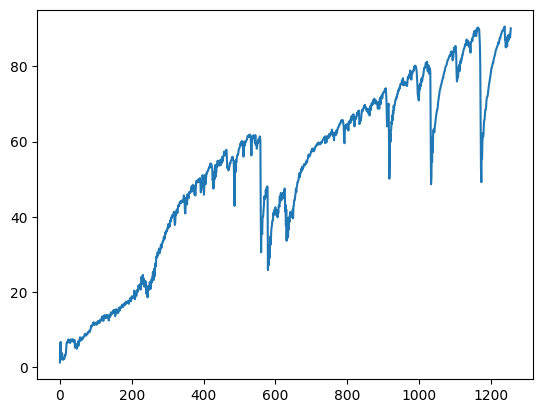

In [9]:
plt.plot(accs)

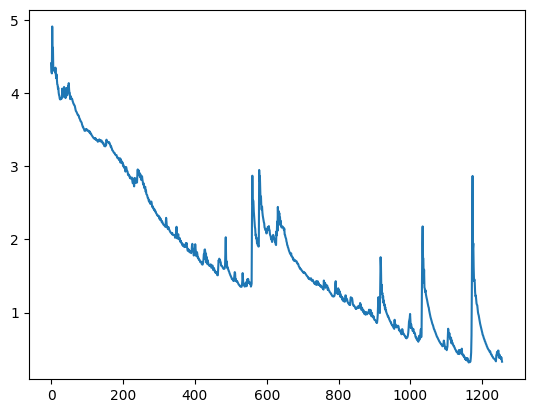

In [10]:
plt.plot(losses)

In [11]:
model.eval()
out = model(data.x, data.RWPE, data.edge_index)
pred = out.argmax(dim=-1)
correct = (pred[~data.train_mask] == data.y[~data.train_mask])
acc = int(correct.sum()) / int(correct.shape[0])
f1 = f1_score(data.y[~data.train_mask.cpu()].cpu(), pred[~data.train_mask.cpu()].cpu(), average='micro')
report = pd.DataFrame(classification_report(data.y[~data.train_mask.cpu()].cpu(), pred[~data.train_mask.cpu()].cpu(), output_dict=True)).T

In [12]:
result_sliced = report.iloc[:-3 if len(report) < 23 else 20, :]
acc = report.loc['accuracy'][0]
report.loc['minorities-f1',:] = result_sliced.mean(axis=0)
print(f'Test Acc: {100*acc}')

Test Acc: 42.4219228413962


In [13]:
#GraphSAGE_layers4_neurons256
report.to_csv("/home/sujin/sujin/ds503/results/GPS_layers5_neurons256_SAGE.csv")

In [14]:
train_res_loss = pd.DataFrame({'GPS_layers5_neurons256_SAGE' : losses})
train_res_loss.to_csv('./results/train_results/GPS_layers5_neurons256_SAGE_loss.csv', index=False)

In [15]:
train_res_acc = pd.DataFrame({'Graph Attention GPS_layers5_neurons320' : accs})
train_res_acc.to_csv('./results/train_results/GPS_layers5_neurons256_SAGE_acc.csv', index=False)